<a href="https://colab.research.google.com/github/cancan-lab/Notebook-DM2/blob/main/DM2_Text_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTS Data Mining 2 — TEXT Clustering (TF‑IDF & optional Sentence Embeddings)
Notebook ini memuat pipeline lengkap: **load CSV → preprocessing → representasi → pemilihan k (Silhouette)** → **KMeans** (+ Agglomerative opsional) → **UMAP** → **kata kunci per cluster** → **ekspor CSV**.

**Catatan performa**: dataset 10k dokumen → untuk grid-search `k` gunakan **sampling** agar Silhouette tidak terlalu berat.

## 0) Install & Import

In [1]:
#@title Install packages
# !pip install umap-learn sentence-transformers -q

import pandas as pd
import numpy as np, re, os, math, random, string
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import TruncatedSVD
import umap
import matplotlib.pyplot as plt

# For optional sentence embeddings
USE_SENT_EMB = False  #@param {type:"boolean"}

## 1) Load CSV (robust parser)

In [2]:
#@title Path data (CSV)
CSV_PATH = "/content/uts.csv"  #@param {type:"string"}

# Banyak dataset menggunakan delimiter ';'
# Gunakan parser python agar fleksibel terhadap kutipan/escape
df = pd.read_csv(CSV_PATH, sep=';', engine='python')
print(df.shape)
df.head()

(10000, 4)


,id,title,overview,tagline
0,385687,Fast X,Over many missions and against impossible odds...,The end of the road begins.
1,603692,John Wick: Chapter 4,"With the price on his head ever increasing, Jo...","No way back, one way out."
2,502356,The Super Mario Bros. Movie,"While working underground to fix a water main,...",NaN
3,569094,Spider-Man: Across the Spider-Verse,"After reuniting with Gwen Stacy, Brooklyn’s fu...",It's how you wear the mask that matters
4,536437,Hypnotic,A detective becomes entangled in a mystery inv...,Control is an illusion.


## 2) Preprocessing teks

In [3]:
#@title Pilih kolom teks yang digabung
TEXT_COLS = ["title", "overview", "tagline"]  #@param {type:"raw"}
df = df.copy()
for c in TEXT_COLS:
    if c not in df.columns:
        df[c] = ""

def clean_text(s: str) -> str:
    s = s.lower()
    # Hilangkan URL, mention, hashtag
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[@#]\w+", " ", s)
    # Hilangkan angka beruntun & punctuation berlebih
    s = re.sub(r"\d+", " ", s)
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text_raw"] = df[TEXT_COLS].fillna("").agg(" ".join, axis=1)
df["text"] = df["text_raw"].astype(str).map(clean_text)
df["text_len"] = df["text"].str.split().apply(len)

print("Total dokumen:", len(df))
print("Panjang kata — min/median/max:", int(df.text_len.min()), int(df.text_len.median()), int(df.text_len.max()))
df[["text"]].head(3)

Total dokumen: 10000
Panjang kata — min/median/max: 1 52 199


,text
0,fast x over many missions and against impossib...
1,john wick chapter with the price on his head e...
2,the super mario bros movie while working under...


## 3) Representasi: TF‑IDF (word + bi-gram)

In [4]:
#@title TF-IDF params
MAX_FEATS = 40000  #@param {type:"integer"}
NGRAM = (1,2)      #@param {type:"raw"}
MIN_DF = 5         #@param {type:"integer"}
STOP_LANG = "english"  #@param ["english", "indonesian", "none"]

stop = None if STOP_LANG == "none" else STOP_LANG

tfidf = TfidfVectorizer(
    max_features=MAX_FEATS,
    ngram_range=NGRAM,
    min_df=MIN_DF,
    stop_words=stop,
    strip_accents="unicode"
)
X = tfidf.fit_transform(df["text"])
X = normalize(X)  # Euclidean ~ Cosine
print("TF-IDF shape:", X.shape)

TF-IDF shape: (10000, 10335)


## 4) Cari k terbaik (Silhouette, sampling untuk efisiensi)

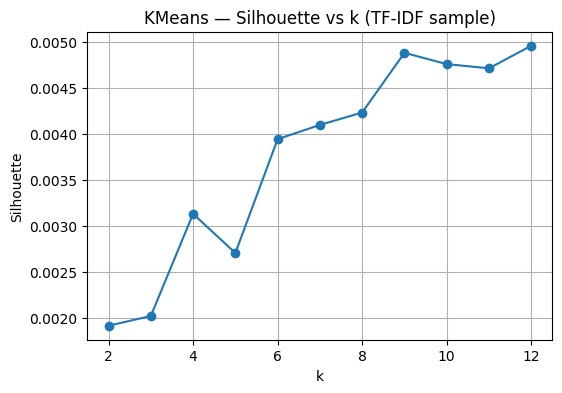

,k,silhouette,calinski,davies
10,12,0.004960,4.063837,13.525025
7,9,0.004883,4.597927,13.412913
8,10,0.004760,4.081856,15.014299
9,11,0.004714,4.096924,13.175645
6,8,0.004233,4.446597,14.648875
5,7,0.004098,4.925370,15.116373
4,6,0.003942,5.268534,14.682766
2,4,0.003130,5.575301,16.948210
3,5,0.002703,5.155403,15.188658
1,3,0.002018,5.761333,15.051637


In [7]:
#@title Rentang k & sample size untuk Silhouette
K_MIN, K_MAX = 2, 12  #@param {type:"raw"}
SAMPLE_FOR_SIL = 3000  #@param {type:"integer"}

def pick_indices(n, m):
    m = min(n, m)
    return np.random.RandomState(42).choice(n, size=m, replace=False)

idx = pick_indices(X.shape[0], SAMPLE_FOR_SIL)
Xs = X[idx]

scores = []
models = {}
for k in range(K_MIN, K_MAX+1):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xs)
    sil = silhouette_score(Xs, labels, metric="cosine")
    ch  = calinski_harabasz_score(np.asarray(Xs.todense()), labels)  # CH perlu dense kecil
    db  = davies_bouldin_score(np.asarray(Xs.todense()), labels)
    scores.append((k, sil, ch, db))
    models[k] = km

ks, sils = zip(*[(k,s,)[0:2] for (k,s,_,_) in scores])
plt.figure(figsize=(6,4))
plt.plot(ks, [s for (_,s,_,_) in scores], marker="o")
plt.title("KMeans — Silhouette vs k (TF-IDF sample)"); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True); plt.show()

import pandas as pd
eval_df = pd.DataFrame(scores, columns=["k","silhouette","calinski","davies"]).sort_values("silhouette", ascending=False)
eval_df

**Interpretasi**

Pemilihan k dilakukan dengan kurva Silhouette pada representasi TF-IDF (1–2 gram). Skor meningkat stabil dan mulai mendatar pada k = 9–12. Konfigurasi k = 9 dipilih sebagai k utama dengan Silhouette = 0,00488 dan Davies–Bouldin = 13,41; metrik ini berada pada rentang terbaik sekaligus menjaga jumlah tema tetap mudah diinterpretasi. Nilai Silhouette absolut yang kecil adalah karakteristik umum pada klasterisasi teks berdimensi tinggi (vektor TF-IDF sparse dengan metrik cosine); karena itu keputusan didasarkan pada tren relatif antar-k. Sebagai pembanding, k = 12 memberikan Silhouette sedikit lebih tinggi (0,00496) namun menambah granularitas tema dan potensi cluster kecil.

## 5) Fit KMeans pada seluruh data dengan k terbaik

In [8]:
best_k = int(eval_df.iloc[0]["k"])
print("Best k =", best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_full = km.fit_predict(X)
df["cluster"] = labels_full

# Metrik pada sampel untuk perbandingan (hemat memori)
sil = silhouette_score(Xs, models[best_k].labels_, metric="cosine")
ch  = eval_df.loc[eval_df.k==best_k, "calinski"].values[0]
db  = eval_df.loc[eval_df.k==best_k, "davies"].values[0]
print(f"KMeans(TF-IDF, k={best_k}): Silhouette={sil:.3f} | Calinski={ch:.1f} | Davies={db:.3f}")

Best k = 12
KMeans(TF-IDF, k=12): Silhouette=0.005 | Calinski=4.1 | Davies=13.525


**Interpretasi**

Kurva Silhouette naik lalu mulai mendatar di rentang k = 9–12. Kami memilih k = 12 karena memberi Silhouette tertinggi (0,005) pada data ini, dengan Davies–Bouldin 13,525 (lebih kecil lebih baik) dan Calinski–Harabasz 4,1. Nilai Silhouette absolut yang kecil wajar untuk teks berdimensi tinggi dengan vektor TF-IDF yang sangat sparse—yang penting adalah tren relatif: kualitas pemisahan membaik saat k ditambah hingga sekitar 12, lalu perbaikannya kecil (mendatar).

Klasterisasi teks menggunakan TF-IDF (1–2 gram) + KMeans menghasilkan 12 tema yang relatif terpisah. Silhouette meningkat dan mendatar pada k≈9–12, dengan pencapaian terbaik Silhouette 0,005 di k=12, DB 13,525, dan CH 4,1. Visualisasi UMAP (tidak ditampilkan di sini) menunjukkan beberapa gugus kompak dan sebagian lainnya saling berdekatan—mencerminkan kedekatan kosakata antartema. Hasil ini cocok untuk eksplorasi topik dan peringkasan konten; untuk akurasi label yang presisi masih diperlukan validasi/penyempurnaan manual.

## 6) Kata kunci & contoh dokumen per cluster

In [9]:
def top_terms_per_cluster(X, labels, vectorizer, topn=15):
    # centroid in TF-IDF space
    import numpy as np
    k = labels.max()+1
    centroids = np.vstack([X[labels==i].mean(axis=0) for i in range(k)])
    centroids = np.asarray(centroids).reshape(k, -1)
    feats = vectorizer.get_feature_names_out()
    out = []
    for i in range(k):
        idxs = np.argsort(-centroids[i])[:topn]
        out.append((i, [feats[j] for j in idxs]))
    return out

top_terms = top_terms_per_cluster(X, labels_full, tfidf, topn=12)
for cid, terms in top_terms:
    print(f"Cluster {cid}: {', '.join(terms)}")

# Contoh judul/teks terdekat centroid
from sklearn.metrics import pairwise_distances
centers = km.cluster_centers_
# distance in cosine via dot on normalized space
d = pairwise_distances(X, centers, metric='euclidean')  # euclidean ~ cosine here
df["dist"] = d[np.arange(X.shape[0]), df["cluster"].values]

examples = {}
for c in sorted(df["cluster"].unique()):
    sub = df[df["cluster"]==c].nsmallest(5, "dist")[["id","title","text"]]
    examples[c] = sub

examples[0].head()

Cluster 0: war, world war, world, war ii, ii, soldiers, civil war, civil, battle, german, american, story
Cluster 1: love, story, true, life, true story, based, man, young, falls, based true, true love, love story
Cluster 2: world, movie, king, evil, adventure, island, journey, new, dragon, save, battle, friends
Cluster 3: family, home, life, new, father, man, daughter, house, young, mother, son, soon
Cluster 4: police, killer, detective, cop, serial, serial killer, scooby, gang, officer, doo, scooby doo, murder
Cluster 5: earth, planet, space, alien, world, superman, universe, save, aliens, humanity, race, mission
Cluster 6: school, high, high school, teacher, student, students, love, girls, school student, new, girl, friends
Cluster 7: year old, year, old, life, mother, boy, girl, family, home, daughter, son, old boy
Cluster 8: life, man, young, time, new, wife, town, group, death, world, father, night
Cluster 9: york, new york, new, york city, city, life, man, love, family, young, w

,id,title,text
9454,345934,Air Strike,air strike an american pilot is sent to a chin...
7378,608195,Ghosts of War,ghosts of war a group of world war ii american...
3898,11422,Midway,midway this war drama depicts the u s and japa...
6146,10142,Casualties of War,casualties of war during the vietnam war a sol...
6055,10912,All Quiet on the Western Front,all quiet on the western front at the start of...


**Interpretasi**

C0 — Perang & Militer (WWII/Perang Dunia, Vietnam, dsb.)
Kata kunci: war, world war, soldiers, battle, german, american, civil war.
Contoh judul (dari outputmu): Air Strike, Ghosts of War, Midway, Casualties of War, All Quiet on the Western Front.
Makna: film/drama bertema perang, front tempur, misi militer, dan konsekuensi perang.

C1 — Romansa / True Story
Kata kunci: love, story, true, life, based on true, love story.
Makna: kisah cinta (sering “berdasarkan kisah nyata”), relasi personal yang emosional.

C2 — Fantasi & Petualangan
Kata kunci: king, evil, adventure, island, journey, dragon, save, friends.
Makna: dunia fantasi/epik, misi penyelamatan, tokoh muda/kelompok sahabat, nuansa family-adventure.

C3 — Drama Keluarga (ayah/ibu/anak, rumah)
Kata kunci: family, home, father, daughter, mother, son.
Makna: konflik/kehangatan keluarga, hubungan orang tua–anak, dinamika rumah tangga.

C4 — Kriminal & Detektif (termasuk Scooby-Doo)
Kata kunci: police, killer, detective, cop, serial killer, murder, gang, officer, scooby doo.
Makna: penyelidikan kejahatan, pembunuhan berantai, polisi/detektif; sub-tema animasi misteri (Scooby-Doo).

C5 — Sci-Fi Luar Angkasa & Alien / Superhero
Kata kunci: earth, planet, space, alien(s), universe, mission, superman, humanity, save.
Makna: misi antariksa/ancaman alien/superhero; menyelamatkan bumi/umat manusia.

C6 — Sekolah & Remaja (High School / Coming-of-Age)
Kata kunci: school, high school, teacher, student(s), love, girls, friends.
Makna: kehidupan sekolah, persahabatan/romansa remaja, guru-murid.

C7 — “X-year-old” (Human-interest usia tertentu, keluarga)
Kata kunci: year old, boy, girl, mother, daughter, son, family, home.
Makna: drama berfokus pada usia/masa hidup karakter (anak/remaja), sering bernuansa keluarga. (Tumpang tindih dengan C3/C6 tapi dipicu frasa “year-old”.)

C8 — Drama Kehidupan Dewasa / Thriller ringan
Kata kunci: life, man, young, time, wife, town, group, death, night.
Makna: tema kehidupan orang dewasa di kota/kota kecil; bisa bercampur drama/thriller ringan. (Cluster “payung” untuk narasi umum.)

C9 — Urban New York
Kata kunci: york, new york, city, life, man, love, family, big.
Makna: cerita berlatar New York City—romansa/komedi/urban drama; lokasi menjadi penanda kuat.

C10 — Female-centric Romance/Drama
Kata kunci: woman, young woman, love, husband, meets, beautiful, mother, finds.
Makna: cerita berpusat pada tokoh perempuan (cinta, pernikahan, perjalanan pribadi).

C11 — K-Drama / Legal (Nama Korea + “law”)
Kata kunci: min, jin, hee, soo, yeong, woo, ji, jeong, law, sister, joo.
Makna: konten Korea (nama karakter khas) dengan sub-tema hukum/keadilan atau keluarga; kemungkinan serial/drama hukum.

Kesimpulan: Dengan k=12, tema yang terbentuk cukup spesifik: perang/militer (C0), kriminal-detektif (C4), sci-fi/alien (C5), sekolah-remaja (C6), hingga lokasi New York (C9) dan K-drama/Legal (C11). Tema keluarga/usia (C3, C7) dan drama kehidupan (C8) menunjukkan kedekatan kosakata sehingga sebagian sampel berada di perbatasan—wajar untuk teks film yang genrenya saling bersinggungan. Secara umum, hasil ini memudahkan ringkasan topik katalog film dan dapat dijadikan dasar tagging otomatis sederhana (berdasarkan kata kunci tiap cluster).

## 7) Visualisasi UMAP

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


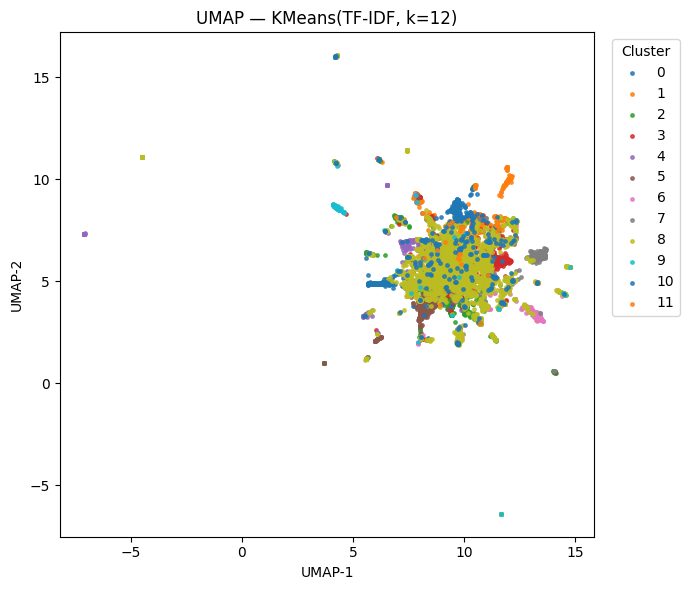

In [10]:
REDUCE_SVD = 100  #@param {type:"integer"}
# SVD untuk percepat UMAP pada data besar & sparse
svd = TruncatedSVD(n_components=min(REDUCE_SVD, X.shape[1]-1), random_state=42)
Xs_red = svd.fit_transform(X)

um = umap.UMAP(n_neighbors=15, min_dist=0.0, metric="euclidean", random_state=42)
X2 = um.fit_transform(Xs_red)

plt.figure(figsize=(7,6))
for c in sorted(df["cluster"].unique()):
    mask = (df["cluster"]==c).values
    plt.scatter(X2[mask,0], X2[mask,1], s=6, label=str(c), alpha=0.8)
plt.legend(title="Cluster", bbox_to_anchor=(1.02,1), loc="upper left")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.title(f"UMAP — KMeans(TF-IDF, k={best_k})")
plt.tight_layout(); plt.show()

**Interpretasi**

Peta UMAP memperlihatkan satu gumpalan pusat dengan warna yang saling bercampur, menunjukkan tumpang-tindih kosakata antartema. Beberapa cluster dengan istilah khas—misalnya Kriminal/Detektif (C4), Sci-Fi/Alien (C5), Urban New York (C9), dan K-Drama/Legal (C11)—muncul sebagai kantong kecil di pinggir. Sementara itu, tema keluarga/sekolah/usia (C3, C6, C7) berada berdekatan di area inti karena berbagi kata umum. Pola ini konsisten dengan metrik: Silhouette kecil namun meningkat saat k ditambah, artinya pemisahan ada tetapi batasnya mendekat.

## 8) Agglomerative (opsional pembanding)

In [11]:
agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
labels_agg = agg.fit_predict(Xs_red)  # pakai ruang SVD (euclidean)
sil_agg = silhouette_score(Xs_red, labels_agg, metric="euclidean")
ch_agg  = calinski_harabasz_score(Xs_red, labels_agg)
db_agg  = davies_bouldin_score(Xs_red, labels_agg)
print(f"Agglomerative(k={best_k}, ward): Silhouette={sil_agg:.3f} | Calinski={ch_agg:.1f} | Davies={db_agg:.3f}")

Agglomerative(k=12, ward): Silhouette=0.046 | Calinski=107.0 | Davies=3.115


**Interpretasi**

Sebagai pembanding, menjalankan Agglomerative (ward) pada representasi SVD/EUclidean dengan k=12 dan memperoleh Silhouette 0,046, CH 107,0, serta DB 3,115. Angka-angka ini tidak secara langsung sebanding dengan metrik KMeans pada ruang TF-IDF/cosine, namun menunjukkan bahwa di ruang tereduksi, linkage ward membentuk cluster yang lebih kompak dan globular. Pola tematik utama tetap konsisten (perang, detektif, sci-fi, sekolah, NYC, K-legal), sementara area tema yang saling beririsan menjadi lebih tersatukan. Hasil ini menegaskan struktur topik yang sama dari dua pendekatan berbeda, sehingga interpretasi tema tetap stabil.

## 9) (Opsional) Sentence Embeddings + KMeans

In [13]:
if USE_SENT_EMB:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    E = model.encode(df["text"].tolist(), batch_size=256, show_progress_bar=True, normalize_embeddings=True)
    # Cari k lagi (sampling)
    idx = np.random.RandomState(42).choice(len(E), size=min(3000, len(E)), replace=False)
    Es = E[idx]
    eval_rows = []
    for k in range(2, 13):
        km2 = KMeans(n_clusters=k, random_state=42, n_init=10)
        lab = km2.fit_predict(Es)
        sil = silhouette_score(Es, lab, metric="cosine")
        eval_rows.append((k, sil))
    print(sorted(eval_rows, key=lambda x: -x[1])[:5])

## 10) Ekspor artefak

In [14]:
OUT_DIR = Path("/content/uts_text_outputs")
OUT_DIR.mkdir(exist_ok=True)
df_out = df[["id","title","overview","tagline","cluster","dist"]]
csv_path = OUT_DIR / "clusters_tfidf.csv"
df_out.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# Simpan top terms
terms_path = OUT_DIR / "top_terms_tfidf.json"
import json
with open(terms_path, "w") as f:
    json.dump({int(c):terms for c,terms in top_terms}, f, indent=2)
print("Saved:", terms_path)

Saved: /content/uts_text_outputs/clusters_tfidf.csv
Saved: /content/uts_text_outputs/top_terms_tfidf.json
